The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Xtr  (50000, 32, 32, 3)
Ytr  (50000,)
Xte  (10000, 32, 32, 3)
Yte  (10000,)


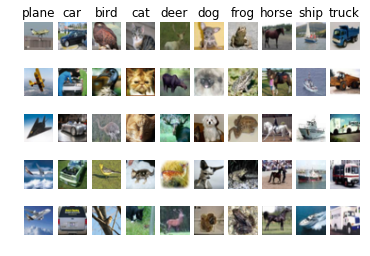

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext jupyter_cms

import numpy as np
import random
import matplotlib.pyplot as plt
from utils import cifar_dataset_util

# load data.. refer to utils/cifar_dataset_util.ipynb 
# for the method that load and decompress CIFAR-10 ** load_all_cifar10(..) **
# helper methods to download CIFAR-10 provided
# by toronto.edu dataset & decompress it 
# --------------------------------------------

cifar_path = "./datasets/cifar-10-batches-py"
Xtr, Ytr, Xte, Yte = cifar_dataset_util.load_all_cifar10(cifar_path)

print "Xtr ", Xtr.shape
print "Ytr ", Ytr.shape
print "Xte ", Xte.shape
print "Yte ", Yte.shape

# plot some images from the loaded data
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = Xtr[mask]
y_val = Ytr[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = Xtr[mask]
y_train = Ytr[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = Xtr[mask]
y_dev = Ytr[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = Xte[mask]
y_test = Yte[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


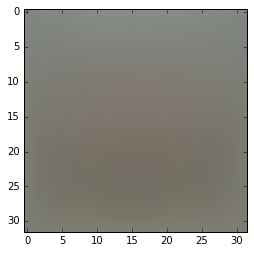

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data

# Important note is that the mean is computed on training 
# set and then substrcted from train, test andvalidation dataset
# ----------------------------------------------------------------

mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# so called bias TRICK
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


##### Now we will start SVM classifier
- we will develope a method to compute the loss function 

In [49]:
from IPython.core.debugger import Tracer

class LinearSVMClassifier(object):
    
    """ 
    classier will provide the API train to train the model 
    predict to make prediction  
    """
    def __init__(self):
        pass
    
    def train(self):
        pass
    
    def predict(self):
        pass
    
    
def svm_loss_naive(W, X, y, reg=0.00001):
    """
    W is matrix of size [D=3073, C=10]
    X numpy array of shape (N=500, D=3073)
    y numpy array of shape (N=500, 1)
    """
    delta = 1 # the SVM margin
    loss = 0.0 # here we will store the loss of our score funtion hinge function
    dW = np.zeros(W.shape) # gradient of the loss function with respect to W parameters 
    
    num_train = X.shape[0]
    num_class = W.shape[1]
    
    for i in xrange(num_train):
        # here we will store gradient of the loss for each sample
        dLi = np.zeros(W.shape)
        counter = 0.0
        scores = np.dot(X[i], W)
        correct_class_score = scores[y[i]]
        
        for j in range(num_class):
         
            if j == y[i]:
                continue
            
            margin = scores[j] - correct_class_score + delta
            
            # max(0, margin)
            if margin > 0:
                counter += 1
                loss += margin
                # gradient for j # y[i]
                dLi[:, j] = X[i]
        # gradient for y[i]
        dLi[:, y[i]] = -1.0 * counter * X[i]
        dW += dLi
    # Tracer()()
    # important dont forget to add to the gradient
    # gradient of regularization part  
    dW = (1.0/num_train)*dW + reg*W
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    return loss, dW

def svm_loss_vectorized(W, X, y, reg=0.00001):
    
    dW = np.zeros(W.shape)
    loss = 0.0 
    scores = np.dot(X, W) # matrix [N=500, C=10]
    delta = np.ones(scores.shape) # = 1 SVM margin
    correct_classes_scores = scores[range(y.shape[0]), y]
    loss = scores - correct_classes_scores.reshape(-1, 1) + delta
    # shift the < 0 values in loss to ZERO
    loss[loss < 0] = 0
    # shift all correct classes scores to ZERO too
    loss[range(y.shape[0]), y] = 0
    loss = np.sum(loss)
    
    loss /= y.shape[0]
    
    loss += 0.5 * reg * np.sum(W * W)
    
    L = scores - correct_classes_scores.reshape(-1, 1) + delta
    L[L < 0] = 0
    L[L > 0] = 1
    L[range(y.shape[0]), y] = -1.0 * np.sum(L, axis=1)
    dW = np.dot(X.T, L)
    dW = (1.0/y.shape[0]) * dW + reg * W
    
    return loss, dW


In [50]:
# Evaluate the performance of the svm_loss_naive function

# start by generating a random weights
W = np.random.randn(3073, 10) * 0.001

loss, dW = svm_loss_naive(W, X_dev, y_dev) # regularization is 0.00001 
print 'loss is %f' % loss

loss is 25.351444


In [51]:
# check svm_loss_vectorized must be the same !! and vaster
from time import time

tic = time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

tic = time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 2.535144e+01 computed in 0.092914s
Vectorized loss: 2.535144e+01 computed in 0.007213s
difference: 0.000000


In [52]:
tic = time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.090289s
Vectorized loss and gradient: computed in 0.006657s
difference: 295.003499


In [56]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.085823s
Vectorized loss and gradient: computed in 0.007484s
difference: 295.003499
